# Should I invest in SpaceX?
And if so, what amount?

Here's what I did.
1. Get assumptions regarding drivers of SpaceX growth from publically available sources (ex. "commercial heavy launch market will grow 15% YoY through 2027")
2. Layer in my own assumptions about the potential ranges of those drivers. (ex. "I think the potential range of commercial heavy launch could be anywhere from -15% to 45%, assuming a normal distribution")
3. Run a Monte Carlo simulation, where I simulate 10,000 different outcomes for future SpaceX valuations based on my assumptions
4. Based on Monte Carlo results, calculate the Kelly Criterion (https://en.wikipedia.org/wiki/Kelly_criterion) which determines the optimal position size (as a percentage of your current wealth) to "wager" to maximize expected wealth
5. Decide to invest any amount up to the kelly criterion

## DISCLAIMER
NOTE: The information herein is not investment advice. Author does not warrant that any of the information herein is correct. It is for informational purposes only. All assumptions - including those sourced from publically available sources and those made by the author could be very wrong. There could be mathematical errors in the author's calculations. Additionally, logical assumptions made in creating the mathematical models herein could be misguided. 

By proceeding further, you, the reader, accept all risk and liability for investment decisions you make (or do not make) based on the information herein. The author is not liable for any risk or loss of capital for investment decisions made (or not made) using this information. 

## Publically available data used for assumptions

### SpaceX 2022 revenue estimates
Source: https://payloadspace.com/spacexs-22-revenues-a-reformed-wall-street-analysts-best-guess/
- Launch revenue: 2.7 billion (USD)
- Starlink revenue: 980M (USD)
- Current starlink subscribers: 745,000 EOY 2022 (estimated)

### Current SpaceX valuation
Source: https://www.google.com/search?q=spacex+valuation&oq=spacex+valuation&aqs=chrome..69i57j69i61.4812j0j15&sourceid=chrome&ie=UTF-8
- Valuation: 137 billion (USD)

### Growth assumption & sources
Source: https://stonky.notion.site/SpaceX-Memo-b1e61b0e59bb4a72b268bf59599bd06f
- Commercial Launch Market CAGR: 15.7%
- SpaceX current commercial launch market share: 60%
- Starlink: This is a little more complicated. The source above cite's SpaceX's estimate of 40 million subscribers by EOY 2025. That would be 277% CAGR. This would mean Starlink's subscriber base would exeed the earth's population by about 2028... so I think that number is too high. I just made up my own "conservative" estimate of **50% CAGR**

### Additional assumptions
1. I calcualted the current (estimated) price-to-sales ratio of 51.62 (137 billion / 2.7 billion)

### Assumption ranges for Monte Carlo
I assumed a 50% standard devation for each metric and assumed a normal distribution.
For example, assuming a commercial launch market CAGR of 15.7%, my simulation tests hypothetical actual CAGRs sampled from a normal distribution with a mean of 15.7% and a standard devation of 7.85% (50% of 15.7%)

### Monte Carlo Simulation
My monte carlo process simulates 10,000 possible SpaceX valuations by EOY 2025



## Code Inputs

In [21]:
# current launch and starlink revenue
current = {
    "launch": 2270000000.00,
    "starlink":980000000.00
}

# base assumptions described above
base_assumptions = {
    "value":{"launch_market_growth":0.157,
        "launch_market_share": 0.6,
        "starlink_annual_subscriber_growth":0.5,
        "assumed_ps_ratio":51.62
    }
    ,"pct_std_dev":{"launch_market_growth":0.5,
        "launch_market_share": 0.5,
        "starlink_annual_subscriber_growth":0.5,
        "assumed_ps_ratio":0.25
    }
}


years = 3 #running simulation 3 years out
runs = 10000 #number of times to run simulation for monte carlo
current_valuation = 137000000000 #current SpaceX valuation
working_capital = 250000 #hypothetical investible capital

#where all the magic happens. All results stored in the spaceX instance of the Analysis class
spaceX = Analysis(current,base_assumptions,years,runs,current_valuation,working_capital)


## Results and discussion

### F_max
This is the portion of my working capital that is mathematically optimum to "wager" given my assumptions

In [19]:
print("f_max:",spaceX.f_max)

f_max: 1.0


An f_max of 1 means that I should go all-in, wagering 100% of my working capital on this :)

### Forecasted distribution of absolute returns
This is the forecasted absolute return by EOY 2025. A value of 1 means a 100% return.
Note, this is not a CAGR. Also, this simulation does not assume any future dilution of ownership.

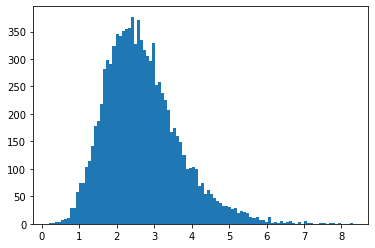

Expected absolute return (mean of simulated outcomes): 2.69
Expected SpaceX valuation (mean of simulated outcomes): 368530000000.0


In [22]:
spaceX.absolute_return_distribution()
expected_return = round(np.mean(spaceX.absolute_returns),2)
expected_valuation = current_valuation * expected_return
print("Expected absolute return (mean of simulated outcomes):",expected_return)
print("Expected SpaceX valuation (mean of simulated outcomes):",expected_valuation)

## The Code

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

class Analysis:
    def __init__(self,current,base_assumptions,years,runs,current_valuation,working_capital):
        self.current = current
        self.base_assumptions = base_assumptions
        self.years = years
        self.runs = runs
        self.current_valuation = current_valuation
        self.working_capital = working_capital
        
        self.valuations = self.calculate_valuations()
        self.valuations = np.where(np.array(self.valuations) < 0,0,np.array(self.valuations))
        
        self.absolute_returns = [v / self.current_valuation for v in self.valuations]
        self.f_max, self.f_values, self.g_values = self.calc_kelly()
        self.investment_amount = self.calc_investment_amount()
        

    def calculate_future_valuation(self,current,assumptions):
    
        current_launch_revenue = current["launch"]
        current_starlink_revenue = current["starlink"]
    
        assumed_launch_market_growth = assumptions["launch_market_growth"]
        assumed_launch_market_share = assumptions["launch_market_share"]
        assumed_subscriber_growth = assumptions["starlink_annual_subscriber_growth"]
        assumed_ps_ratio = assumptions["assumed_ps_ratio"]
    
        future_launch_revenue = current_launch_revenue * (1 + assumed_launch_market_growth) ** self.years
        future_starlink_revenue = current_starlink_revenue * (1 + assumed_subscriber_growth) ** self.years
        future_total_revenue = future_launch_revenue + future_starlink_revenue
    
        future_valuation = future_total_revenue * assumed_ps_ratio
    
        return future_valuation
        
    def generate_value_array(self,val,std_dev,runs):
    
        vals = val * np.random.normal(1,std_dev,runs)
    
        return vals
    
    def calculate_valuations(self):
    
        launch_market_growth_values =       self.generate_value_array(self.base_assumptions["value"]["launch_market_growth"],self.base_assumptions["pct_std_dev"]["launch_market_growth"],self.runs)
        launch_market_share_values =        self.generate_value_array(self.base_assumptions["value"]["launch_market_share"],self.base_assumptions["pct_std_dev"]["launch_market_share"],self.runs)
        assumed_subscriber_growth_values =  self.generate_value_array(self.base_assumptions["value"]["starlink_annual_subscriber_growth"],self.base_assumptions["pct_std_dev"]["starlink_annual_subscriber_growth"],self.runs)
        assumed_ps_ratio_values =           self.generate_value_array(self.base_assumptions["value"]["assumed_ps_ratio"],self.base_assumptions["pct_std_dev"]["assumed_ps_ratio"],self.runs)
    
        valuations = []
    
        for i in range(self.runs):
        
            assumptions = {
                "launch_market_growth":launch_market_growth_values[i],
                "launch_market_share": launch_market_share_values[i],
                "starlink_annual_subscriber_growth":assumed_subscriber_growth_values[i],
                "assumed_ps_ratio":assumed_ps_ratio_values[i]
            }
        
            valuation = self.calculate_future_valuation(current,assumptions)
            valuations.append(valuation)
    
        return valuations
        
    def valuation_distribution(self):
        plt.hist(self.valuations,bins = 100)
        plt.show()
        
        return
        
    def absolute_return_distribution(self):
        plt.hist(self.absolute_returns,bins = 100)
        plt.show()
        
        return
        
    def calc_G(self,df_bins_agg,f,dS):
    
        G = 0
    
        for index, row in df_bins_agg.iterrows():
        
            s = row.bin_bucket.right
            p = row.norm_absolute_returns
        
            try:
                G = G + math.log(1 + f * s) * p * dS
            except:
                return -1
    
        return G

    def calc_f_max(self,f_values,g_values):
    
        f = f_values[0]
    
        prev_g = 0
    
        for i in range(len(g_values)):
            if i > 0:
                if g_values[i] > prev_g:
                    f = f_values[i]
                else:
                    return f
                
        return f

    def calc_kelly(self):

        #get min & max of absolute_returns
        A = np.min(self.absolute_returns)
        B = np.max(self.absolute_returns)
        dS = 0.1
    
        s_array = np.arange(A - dS,B + dS,dS)

        #get absolute returns into bins
        bins = pd.cut(x = self.absolute_returns,bins = s_array)
    
        df_bins = pd.DataFrame(data = {
            "absolute_returns":self.absolute_returns,
            "bin_bucket":bins
            })
    
        #aggregate bins
        df_bins_agg = df_bins.groupby("bin_bucket").count().reset_index()
        df_bins_agg["norm_absolute_returns"] = df_bins_agg.absolute_returns / df_bins_agg.absolute_returns.sum()
    
        f_values = np.arange(0.01,1.01,0.01)
        g_values = []
    
        for f in f_values:
            G = self.calc_G(df_bins_agg,f,dS)
            g_values.append(G)
        
        f_max = self.calc_f_max(f_values,g_values)
    
        return f_max,f_values,g_values
        
    def calc_investment_amount(self):
        
        return self.working_capital * self.f_max